In [4]:
!pip install stable-baselines3[extra] gymnasium pygame
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import torch

class TradingEnv(gym.Env):
    def __init__(self, max_steps=200):
        super().__init__()
        self.max_steps = max_steps
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        self.reset()
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = 1000.0
        self.shares = 0
        self.price = 100.0
        self.price_history = [self.price]
        return self._get_obs(), {}
    def _get_obs(self):
        price_trend = np.mean(self.price_history[-5:]) if len(self.price_history) >= 5 else self.price
        return np.array([
            self.balance / 1000.0,
            self.shares / 10.0,
            self.price / 100.0,
            price_trend / 100.0,
            self.current_step / self.max_steps
        ], dtype=np.float32)
    def step(self, action):
        self.current_step += 1
        trend = 0.001 * np.sin(self.current_step / 20)
        self.price *= (1 + trend + np.random.normal(0, 0.02))
        self.price = np.clip(self.price, 50, 200)
        self.price_history.append(self.price)
        reward = 0
        if action == 1 and self.balance >= self.price:
            shares_to_buy = int(self.balance / self.price)
            cost = shares_to_buy * self.price
            self.balance -= cost
            self.shares += shares_to_buy
            reward = -0.01
        elif action == 2 and self.shares > 0:
            revenue = self.shares * self.price
            self.balance += revenue
            self.shares = 0
            reward = 0.01
        portfolio_value = self.balance + self.shares * self.price
        reward += (portfolio_value - 1000) / 1000
        terminated = self.current_step >= self.max_steps
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {"portfolio": portfolio_value}
    def render(self):
        print(f"Step: {self.current_step}, Balance: ${self.balance:.2f}, Shares: {self.shares}, Price: ${self.price:.2f}")

In [5]:
class ProgressCallback(BaseCallback):
    def __init__(self, check_freq=1000, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            mean_reward = np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer])
            self.rewards.append(mean_reward)
            if self.verbose:
                print(f"Steps: {self.n_calls}, Mean Reward: {mean_reward:.2f}")
        return True

print("=" * 60)
print("Setting up custom trading environment...")
env = TradingEnv()
check_env(env, warn=True)
print("✓ Environment validation passed!")
env = Monitor(env)
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True)

Setting up custom trading environment...
✓ Environment validation passed!


In [6]:
print("\n" + "=" * 60)
print("Training multiple RL algorithms...")
algorithms = {
    "PPO": PPO("MlpPolicy", vec_env, verbose=0, learning_rate=3e-4, n_steps=2048),
    "A2C": A2C("MlpPolicy", vec_env, verbose=0, learning_rate=7e-4),
}
results = {}
for name, model in algorithms.items():
    print(f"\nTraining {name}...")
    callback = ProgressCallback(check_freq=2000, verbose=0)
    model.learn(total_timesteps=50000, callback=callback, progress_bar=True)
    results[name] = {"model": model, "rewards": callback.rewards}
    print(f"✓ {name} training complete!")

print("\n" + "=" * 60)
print("Evaluating trained models...")
eval_env = Monitor(TradingEnv())
for name, data in results.items():
    mean_reward, std_reward = evaluate_policy(data["model"], eval_env, n_eval_episodes=20, deterministic=True)
    results[name]["eval_mean"] = mean_reward
    results[name]["eval_std"] = std_reward
    print(f"{name}: Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")

Output()


Training multiple RL algorithms...

Training PPO...


Output()

✓ PPO training complete!

Training A2C...


✓ A2C training complete!

Evaluating trained models...
PPO: Mean Reward = 0.00 +/- 0.00
A2C: Mean Reward = 0.00 +/- 0.00



Generating visualizations...


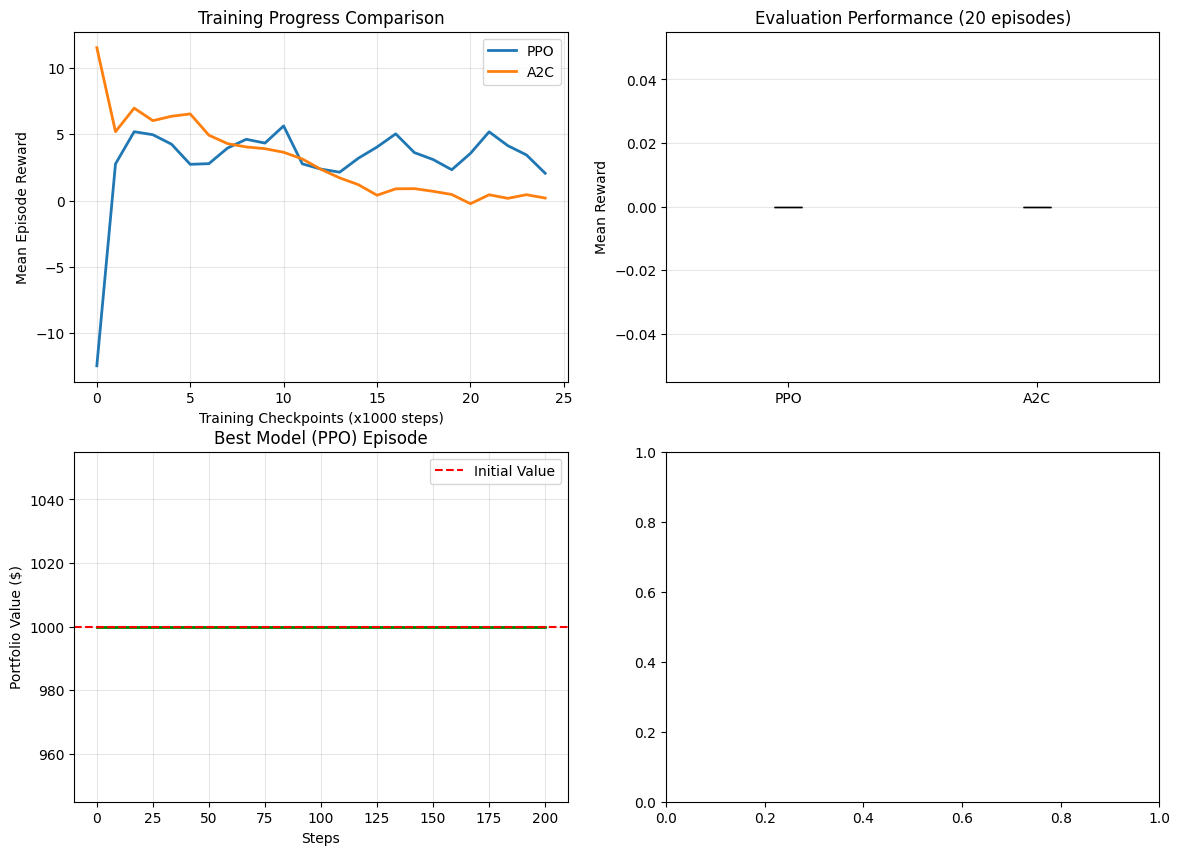

In [7]:
print("\n" + "=" * 60)
print("Generating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax = axes[0, 0]
for name, data in results.items():
    ax.plot(data["rewards"], label=name, linewidth=2)
ax.set_xlabel("Training Checkpoints (x1000 steps)")
ax.set_ylabel("Mean Episode Reward")
ax.set_title("Training Progress Comparison")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
names = list(results.keys())
means = [results[n]["eval_mean"] for n in names]
stds = [results[n]["eval_std"] for n in names]
ax.bar(names, means, yerr=stds, capsize=10, alpha=0.7, color=['#1f77b4', '#ff7f0e'])
ax.set_ylabel("Mean Reward")
ax.set_title("Evaluation Performance (20 episodes)")
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 0]
best_model = max(results.items(), key=lambda x: x[1]["eval_mean"])[1]["model"]
obs = eval_env.reset()[0]
portfolio_values = [1000]
for _ in range(200):
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = eval_env.step(action)
    portfolio_values.append(info.get("portfolio", portfolio_values[-1]))
    if done:
        break
ax.plot(portfolio_values, linewidth=2, color='green')
ax.axhline(y=1000, color='red', linestyle='--', label='Initial Value')
ax.set_xlabel("Steps")
ax.set_ylabel("Portfolio Value ($)")
ax.set_title(f"Best Model ({max(results.items(), key=lambda x: x[1]['eval_mean'])[0]}) Episode")
ax.legend()
ax.grid(True, alpha=0.3)

In [8]:
ax = axes[1, 1]
obs = eval_env.reset()[0]
actions = []
for _ in range(200):
    action, _ = best_model.predict(obs, deterministic=True)
    actions.append(action)
    obs, _, done, truncated, _ = eval_env.step(action)
    if done:
        break
action_names = ['Hold', 'Buy', 'Sell']
action_counts = [actions.count(i) for i in range(3)]
ax.pie(action_counts, labels=action_names, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax.set_title("Action Distribution (Best Model)")
plt.tight_layout()
plt.savefig('sb3_advanced_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualizations saved as 'sb3_advanced_results.png'")
plt.show()

print("\n" + "=" * 60)
print("Saving and loading models...")
best_name = max(results.items(), key=lambda x: x[1]["eval_mean"])[0]
best_model = results[best_name]["model"]
best_model.save(f"best_trading_model_{best_name}")
vec_env.save("vec_normalize.pkl")
loaded_model = PPO.load(f"best_trading_model_{best_name}")
print(f"✓ Best model ({best_name}) saved and loaded successfully!")
print("\n" + "=" * 60)
print("TUTORIAL COMPLETE!")
print(f"Best performing algorithm: {best_name}")
print(f"Final evaluation score: {results[best_name]['eval_mean']:.2f}")
print("=" * 60)

✓ Visualizations saved as 'sb3_advanced_results.png'


<Figure size 640x480 with 0 Axes>


Saving and loading models...
✓ Best model (PPO) saved and loaded successfully!

TUTORIAL COMPLETE!
Best performing algorithm: PPO
Final evaluation score: 0.00
